In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf
from sklearn.cluster import KMeans

In [9]:
SGA_df = pd.read_csv("/home/hduser/Documents/Steam Game Analysis/steam-200k.csv", header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])
SGA_df.head()

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [10]:
SGA_df = SGA_df.drop('Other', axis = 1)
SGA_df.loc[SGA_df['Action'] == 'play'].describe()

,UserID,Hours
count,7.048900e+04,70489.000000
mean,1.058812e+08,48.878063
std,7.150365e+07,229.335236
min,5.250000e+03,0.100000
25%,4.934256e+07,1.000000
50%,9.169067e+07,4.500000
75%,1.556738e+08,19.100000
max,3.099031e+08,11754.000000


In [11]:
print("Number of users : {0}".format(len(SGA_df.UserID.unique())))
print("Number of games : {0}".format(len(SGA_df.Game.unique())))
print("Number of total purchases : {0}".format(len(SGA_df.loc[SGA_df['Action'] == 'purchase'])))
print("Number of total plays infos : {0}".format(len(SGA_df.loc[SGA_df['Action'] == 'play'])))

Number of games : 5155
Number of users : 12393
Number of total purchases : 129511
Number of total plays infos : 70489


In [15]:
values = SGA_df.groupby(['UserID', 'Action']).size()
values.head(10)

UserID  Action  
5250    play         6
        purchase    21
76767   play        20
        purchase    36
86540   play        15
        purchase    82
103360  purchase    10
144736  play         1
        purchase     8
181212  play         2
dtype: int64

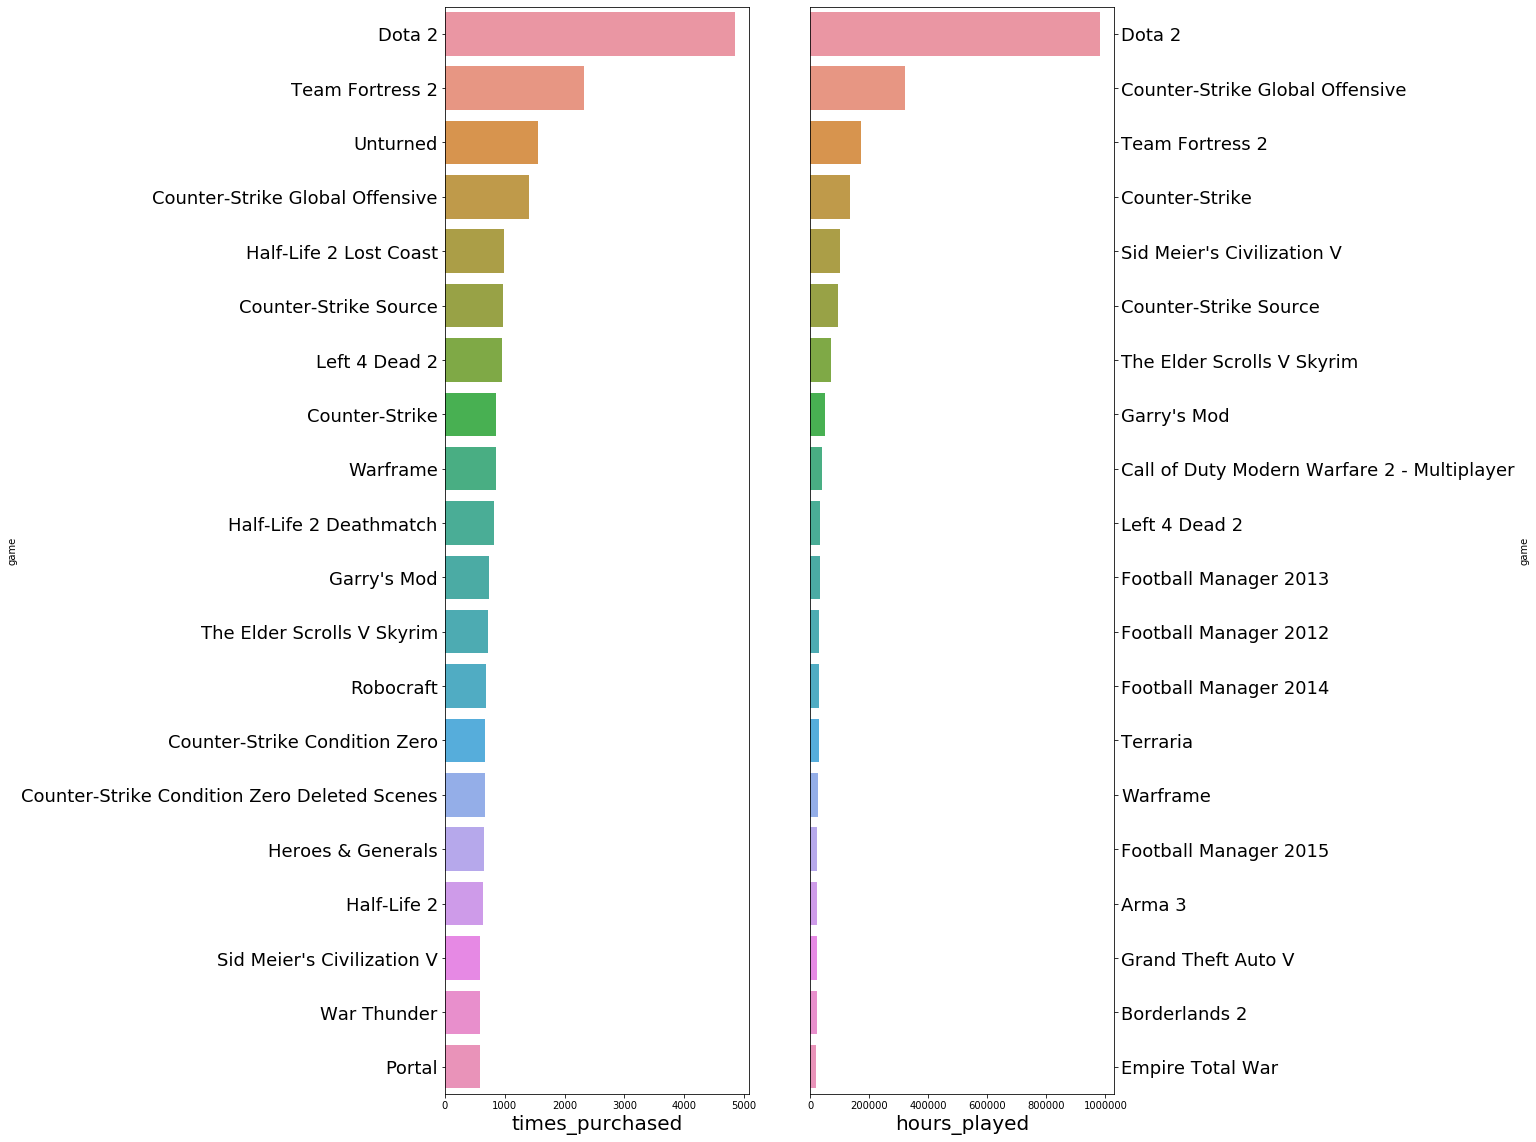

In [18]:
nb_games = 20
df_purchase = SGA_df.loc[SGA_df['Action'] == 'purchase']
purchased_times = df_purchase.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]

df_play = SGA_df.loc[SGA_df['Action'] == 'play']
hours_played = df_play.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]
purchased_times.to_csv('purchased_times.csv', sep='\t', encoding='utf-8')
hours_played.to_csv('hours_played.csv', sep='\t', encoding='utf-8')

fig, ax = plt.subplots(1,2,figsize=(12,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)


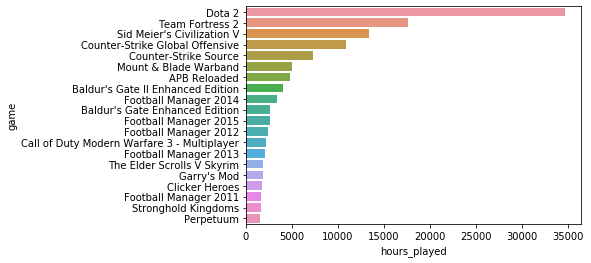

In [19]:
top = 20
user_counts = SGA_df.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)[0:top]
mask = SGA_df['UserID'].isin(user_counts.index)
df_infos_user = SGA_df.loc[mask].loc[SGA_df['Action'] == 'play']
hours_played = df_infos_user.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

sns.barplot(y = 'game', x = 'hours_played', data = hours_played)



# User Classification

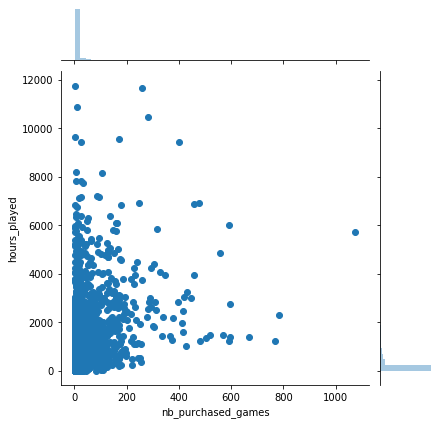

In [21]:
df_purchased_games = SGA_df.loc[SGA_df['Action'] == 'purchase']
df_played_games = SGA_df.loc[SGA_df['Action'] == 'play']

#here we compute the number of games a user has bought
user_counts = df_purchased_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
#here we compute the number of hours he has played 
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

#df creation
user_df_purchased_games = pd.DataFrame({'UserID': user_counts.index, 'nb_purchased_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})

#merge to have one entry per user with number of hours played and number of purchased games
data = pd.merge(user_df_purchased_games, user_df_hours_played, on='UserID')
sns.jointplot(x="nb_purchased_games", y="hours_played", data=data)# , kind="reg")

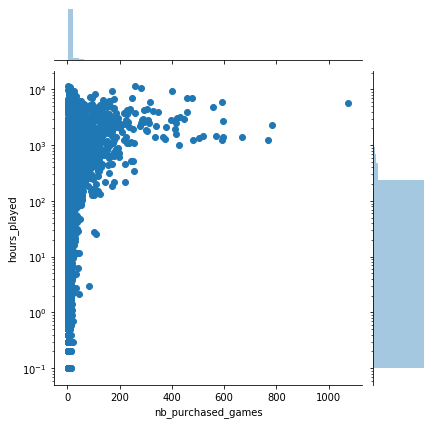

In [22]:
g = sns.jointplot(x="nb_purchased_games", y="hours_played", data=data )#, kind="reg")
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

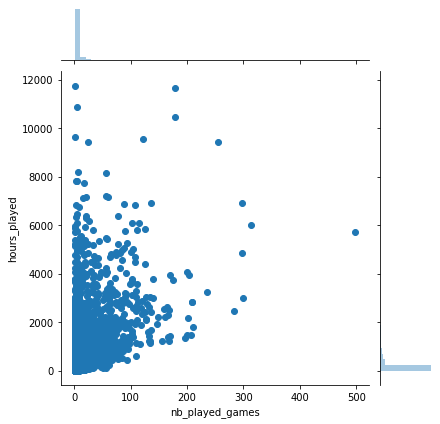

In [23]:
#here we compute the number of games a user has played
user_counts = df_played_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
#here we compute the number of hours he has played 
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

#df creation
user_df_played_games = pd.DataFrame({'UserID': user_counts.index, 'nb_played_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})


#merge to have one entry per user with number of hours played and number of played games
data = pd.merge(user_df_played_games, user_df_hours_played, on='UserID')

sns.jointplot(x="nb_played_games", y="hours_played", data=data )# , kind="reg")


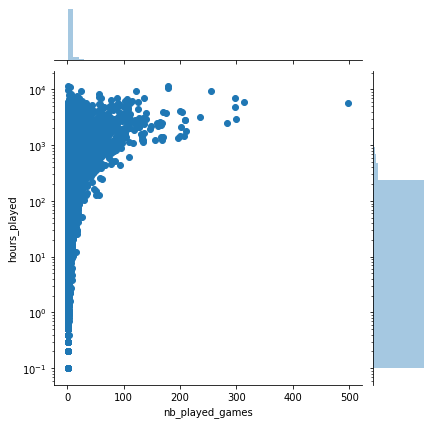

In [24]:
g = sns.jointplot(x="nb_played_games", y="hours_played", data=data )#, kind="reg")
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

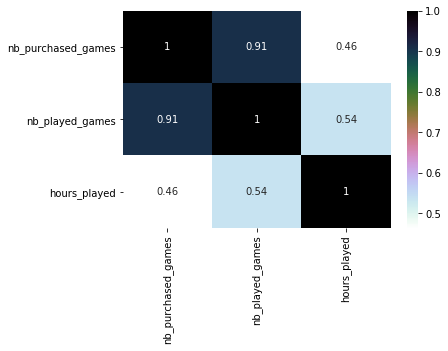

In [25]:
temp = pd.merge(user_df_purchased_games, data, on='UserID')
temp = temp.copy()
del temp['UserID'] #don't need this for k mean
sns.heatmap(temp.corr(),annot=True,cmap='cubehelix_r') #draws  heatmap with input as the correlatio

# K Means

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


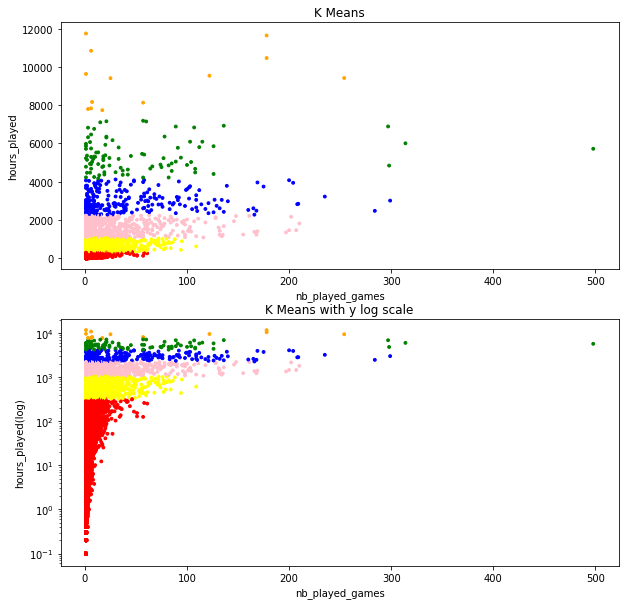

In [26]:
# K Means
temp = data.copy()
del temp['UserID'] #don't need this for k mean

N_CLUSTERS = 6
train_data = temp.as_matrix()
# Using sklearn
km = KMeans(n_clusters=N_CLUSTERS)
km.fit(train_data)
# Get cluster assignment labels
labels = km.labels_ # 0 to n_clusters-1
# Format results as a DataFrame

LABEL_COLOR_MAP = {0 : 'red',
                   1 : 'blue',
                   2 : 'green',
                   3 : 'yellow',
                   4 : 'orange',
                   5 : 'pink'
                  }

label_color = [LABEL_COLOR_MAP[l] for l in labels]


fig, ax =plt.subplots(2,1,figsize=(10,10))
ax[0].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[0].set_xlabel('nb_played_games')
ax[0].set_ylabel('hours_played')
ax[0].set_title('K Means')

ax[1].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[1].set_xlabel('nb_played_games')
ax[1].set_ylabel('hours_played(log)')
ax[1].set_title('K Means with y log scale')
ax[1].set_yscale('log')


## Gaussian Mixture

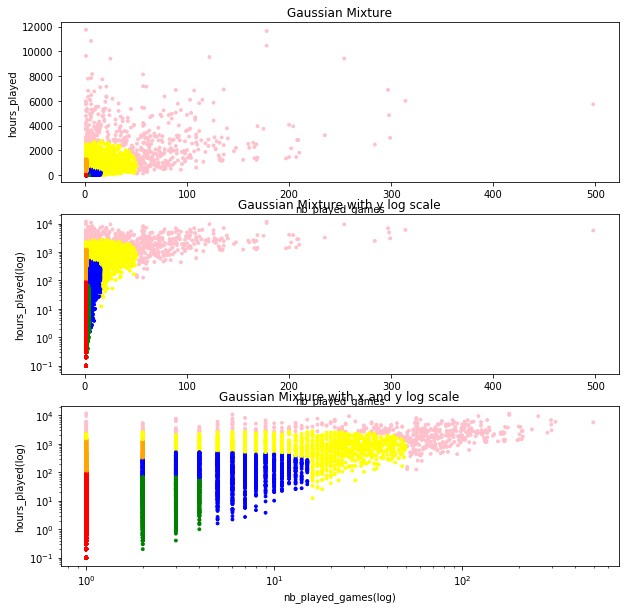

In [27]:
from sklearn.mixture import GaussianMixture
cov_types = ['spherical', 'diag', 'tied', 'full']

gm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag')
gm.fit(train_data)
y_train_pred = gm.predict(train_data)
label_color = [LABEL_COLOR_MAP[l] for l in y_train_pred]

fig, ax =plt.subplots(3,1,figsize=(10,10))
ax[0].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[0].set_xlabel('nb_played_games')
ax[0].set_ylabel('hours_played')
ax[0].set_title('Gaussian Mixture')

ax[1].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[1].set_xlabel('nb_played_games')
ax[1].set_ylabel('hours_played(log)')
ax[1].set_title('Gaussian Mixture with y log scale')
ax[1].set_yscale('log')

ax[2].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[2].set_xlabel('nb_played_games(log)')
ax[2].set_ylabel('hours_played(log)')
ax[2].set_title('Gaussian Mixture with x and y log scale')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
